This is the notebook related to HMM data analysis. To run this, please uncomment all the cells an press "Run all" button.

In [1]:
# Set the path and input parameters
import os
directory = os.getcwd() # the main directory of the project

# The credentials for the remote cluster
name = 'alina'
server = 'ecate'

In [2]:
# Importing the libraries and functions
from functions import *

# HMM analysis

Here we will construct and analyze HMM models retrieved from MSAs. We will utilize several databases as sources to enhance our analysis and gain valuable insights from the generated HMM profiles.
- Reference Proteome 75%: the database of protein sequences.
- Interpro: the database of protein domains.

## 1. hmmsearch results analysis

After performing `hmmsearch` against `RP 75%`, we retrieve the dataframe `hmmsearch_results_clustal` with the statistics.

In [3]:
# Retrieve the dataframe with the hmmsearch results
hmmsearch_results_clustal = pd.read_csv('{}/results/hmms/hmmsearch/hmmsearch_results_clustal.csv'.format(directory))
hmmsearch_results_clustal.head()

,E-value,score,bias,E-value.1,score.1,bias.1,exp,N,Sequence,hmm_from,hmm_to,hmm_length,ali_from,ali_to,ali_length,env_from,env_to,env_length
0,3.800000e-32,122.0,13.1,4.400000e-32,121.8,13.1,1.0,1,A0A8C7BFT3,1,61,61,9,69,61,9,70,62
1,2.400000e-31,119.5,13.6,9.900000e-31,117.5,13.6,2.2,1,A0A3Q7NSQ2,1,62,62,352,413,62,352,413,62
2,3.000000e-31,119.2,13.6,1.400000e-30,117.0,13.6,2.3,1,A0A2U3ZCX9,1,62,62,451,512,62,451,512,62
3,3.000000e-31,119.1,13.6,1.400000e-30,117.0,13.6,2.2,1,A0A2U3VQT6,1,62,62,454,515,62,454,515,62
4,3.100000e-31,119.1,13.6,1.400000e-30,117.0,13.6,2.2,1,A0A3Q7P1S3,1,62,62,451,512,62,451,512,62


Here we compare the length of HMM and the corresponding length of the alignment. There can be 3 options: they are equal or one of them longer or shorter than another because of some insertions/deletions of the alignment.

In [4]:
# Select the length based on a condition
hmms = len(hmmsearch_results_clustal)
match_hmms = len(hmmsearch_results_clustal[hmmsearch_results_clustal['hmm_length'] == hmmsearch_results_clustal['ali_length']])
longer_hmms = len(hmmsearch_results_clustal[hmmsearch_results_clustal['hmm_length'] > hmmsearch_results_clustal['ali_length']])
shorter_hmms = len(hmmsearch_results_clustal[hmmsearch_results_clustal['hmm_length'] < hmmsearch_results_clustal['ali_length']])

# Compare HMMs and alignments lengths
print('The number of HMMs: {}'.format(hmms))
print('- matching the alignment length: {} ({:.2f}%)'.format(match_hmms, match_hmms/hmms * 100))
print('- longer than the alignment length: {} ({:.2f}%)'.format(longer_hmms, longer_hmms/(hmms - match_hmms) * 100))
print('- shorter than the alignment length: {} ({:.2f}%)'.format(shorter_hmms, shorter_hmms/(hmms - match_hmms) * 100))

The number of HMMs: 211312
- matching the alignment length: 99892 (47.27%)
- longer than the alignment length: 27117 (24.34%)
- shorter than the alignment length: 84303 (75.66%)


The number of HMMs matching the length of the alignment and not are more or less equal in proportion **(47,3% and 52,7% respectively)**. Out of non-matching the proportion of the longer HMMs and shorter HMMs is different **(24,3% and 75,7%)**. 

So, mostly we are dealing with the cases where the length of the alignment is longer than the HMM.

In [5]:
# Longer HMMs analysis
longer_clustal = hmmsearch_results_clustal[hmmsearch_results_clustal['hmm_length'] > hmmsearch_results_clustal['ali_length']]
longer_clustal['hmm_ali_diff'] = longer_clustal['hmm_length'] - longer_clustal['ali_length']
longer_clustal.head()

/var/folders/lp/74jh9r6s4zx_dyg2_78l67dw0000gn/T/ipykernel_6386/2507002335.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longer_clustal['hmm_ali_diff'] = longer_clustal['hmm_length'] - longer_clustal['ali_length']


,E-value,score,bias,E-value.1,score.1,bias.1,exp,N,Sequence,hmm_from,hmm_to,hmm_length,ali_from,ali_to,ali_length,env_from,env_to,env_length,hmm_ali_diff
63,7.300000e-29,111.5,13.0,7.300000e-29,111.5,13.0,2.2,1,A0A8J6A1V4,1,62,62,444,504,61,444,504,61,1
80,5.000000e-28,108.8,14.7,5.000000e-28,108.8,14.7,2.5,1,A0A8C9H9L8,1,62,62,445,505,61,445,505,61,1
87,3.100000e-27,106.3,14.4,1.100000e-26,104.5,14.4,2.1,1,A0A8C8YAS1,1,62,62,451,511,61,451,511,61,1
106,3.900000e-26,102.7,15.2,1.700000e-25,100.7,15.2,2.2,1,A0A6G1AVP8,1,62,62,437,497,61,437,497,61,1
115,1.600000e-25,100.8,12.6,5.000000e-25,99.2,12.6,2.0,1,A0A8B7VRK7,2,62,61,423,481,59,422,481,60,2


In [6]:
# Shorter HMMs analysis
shorter_clustal = hmmsearch_results_clustal[hmmsearch_results_clustal['hmm_length'] < hmmsearch_results_clustal['ali_length']]
shorter_clustal['hmm_ali_diff'] = shorter_clustal['ali_length'] - shorter_clustal['hmm_length']
shorter_clustal.head()

/var/folders/lp/74jh9r6s4zx_dyg2_78l67dw0000gn/T/ipykernel_6386/2833219787.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shorter_clustal['hmm_ali_diff'] = shorter_clustal['ali_length'] - shorter_clustal['hmm_length']


,E-value,score,bias,E-value.1,score.1,bias.1,exp,N,Sequence,hmm_from,hmm_to,hmm_length,ali_from,ali_to,ali_length,env_from,env_to,env_length,hmm_ali_diff
132,7.100000e-23,92.3,11.6,7.100000e-23,92.3,11.6,3.1,2,F6XLV7,1,62,62,480,542,63,480,542,63,1
133,1.600000e-22,91.2,16.1,1.600000e-22,91.2,16.1,2.4,1,A0A1A6HSD7,2,62,61,244,306,63,243,306,64,2
139,5.600000e-21,86.2,15.6,2.000000e-20,84.5,15.6,2.0,1,G3HIE4,2,62,61,448,510,63,447,510,64,2
141,1.400000e-20,85.0,16.6,3.600000e-20,83.6,16.6,1.8,1,A0A6J0DUB0,1,62,62,461,525,65,461,525,65,3
142,1.500000e-20,84.9,16.6,3.700000e-20,83.6,16.6,1.7,1,A0A6J0DV05,1,62,62,467,531,65,467,531,65,3


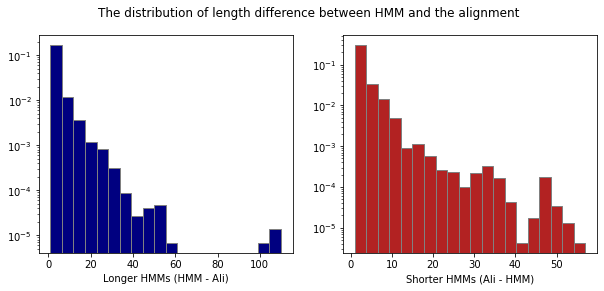

In [7]:
# Plot the 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(longer_clustal['hmm_ali_diff'], bins=20, color='navy', edgecolor='gray', density=True)
ax2.hist(shorter_clustal['hmm_ali_diff'], bins=20, color='firebrick', edgecolor='gray', density=True)

plt.suptitle('The distribution of length difference between HMM and the alignment')
ax1.set_xlabel('Longer HMMs (HMM - Ali)')
ax2.set_xlabel('Shorter HMMs (Ali - HMM)')
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.show()

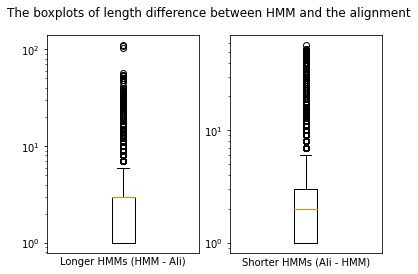

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
ax1.boxplot(longer_clustal['hmm_ali_diff'])
ax2.boxplot(shorter_clustal['hmm_ali_diff'])
plt.suptitle('The boxplots of length difference between HMM and the alignment')
ax1.set_xlabel('Longer HMMs (HMM - Ali)')
ax2.set_xlabel('Shorter HMMs (Ali - HMM)')
ax1.set_xticks(ax1.get_xticks()[1:])
ax2.set_xticks(ax2.get_xticks()[1:]) 
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.show()

In [9]:
# Calculate what share of the outliers is in the data frames
long_outl = len(longer_clustal[longer_clustal['hmm_ali_diff'] >= 10])
short_outl = len(shorter_clustal[shorter_clustal['hmm_ali_diff'] >= 10])

print('Outliers in the longer HMMs (more than 10 aa): {:.2f}%'.format(long_outl/longer_hmms * 100))
print('Outliers in the shorter HMMs (more than 10 aa): {:.2f}%'.format(short_outl/shorter_hmms * 100))

Outliers in the longer HMMs (more than 10 aa): 3.95%
Outliers in the shorter HMMs (more than 10 aa): 2.52%


Retrieving outliers is an important step in our case. Since we cannot use fields `hmm_from/hmm_to` as it doesn't capture the actual position, we need to analyse if the `ali_from/ali_to` are the reliable fields. In case the difference between HMMs and the alignments is huge, we need to find a solution. If the difference is not so big in general, we can rely on the alignment information from the `hmmsearch` results.

Thus, obtaining less than 5% of instances with a huge difference between HMMs and the alignments, we can use the `ali_from/ali_to` columns for the further comparison with Pfam.

## 2. HMM and Pfam comparison

We took the results of `hmmsearch` and performed a search against Interpro database. Thus we obtained the Pfam domains corresponding to the results from `hmmsearch`.

In the following dataframes I directly compared two models: Pfam-HMM and DisProt-HMM. 

3 types of overlap were calculated:
- the common part divided by *Pfam-HMM* length (`overl_pfam`)
- the common part divided by *DisProt-HMM* length (`overl_hmm`)
- and the overall overlap: the common part divided by the **maximum length** combined by Pfam-HMM and DisProt-HMM lengths together (`overl_perc`).

The column `overlap_sym` serves as a quality estimator. If it's less or equal than one, then we calculated the other kinds of overlap correctly.

In [10]:
# Load a dataframe of Pfam regions
pfam_clustal = pd.read_csv('{}/results/pfam/pfam_overlap/pfam_clustal.csv'.format(directory))
print('The number of regions for the hmmsearch results in Interpro:', len(pfam_clustal))
pfam_clustal.head()

The number of regions for the hmmsearch results in Interpro: 1110208


,uniprot_id,pfam_id,ipr_id,start_pfam,end_pfam,length_pfam,hmm_from,hmm_to,hmm_length,ali_from,...,ali_length,env_from,env_to,env_length,overl_len,overl_pfam,overl_ali,non_overl_len,overl_perc,overlap_sym
0,A0A010Q304,PF02775,IPR011766,499,646,148,1,16,16,583,...,16,583,598,16,16,10.81,100.0,133,10.81,19.51
1,A0A010Q304,PF02775,IPR011766,499,646,148,1,40,40,650,...,40,650,690,41,0,0.00,0.0,195,0.00,0.00
2,A0A010Q304,PF00205,IPR012000,289,434,146,1,16,16,583,...,16,583,598,16,0,0.00,0.0,459,0.00,0.00
3,A0A010Q304,PF00205,IPR012000,289,434,146,1,40,40,650,...,40,650,690,41,0,0.00,0.0,617,0.00,0.00
4,A0A010Q304,PF02776,IPR012001,91,205,115,1,16,16,583,...,16,583,598,16,0,0.00,0.0,886,0.00,0.00


Here we will extract the information about Pfam domains which do not overlap **any** of DisProt-HMMs. For this we build a data frame `grouped_pfam` where we sum up all the overlap length for each of the Pfam ID, and then select only the values with 0. 

A simple filtering of the column `overl_len` by 0 shows only the accidental 0 overlap for a combination of a protein and a Pfam domain, but not the domains without overlaps.

In [11]:
# Compare overlapping and non-overlapping Pfam IDs
grouped_pfam = pfam_clustal.groupby('pfam_id')['overl_len'].sum().reset_index() # count all overl_len for each pfam_id
pfam_ids_no_overl = grouped_pfam[grouped_pfam['overl_len'] == 0]['pfam_id'].unique()
pfam_ids_overl = grouped_pfam[grouped_pfam['overl_len'] != 0]['pfam_id'].unique()
print('The total number of Pfam domains:', len(set(pfam_clustal['pfam_id'])))
print('- Non-overlapping DisProt-HMMs:', len(pfam_ids_no_overl))
print('- Overlapping DisProt-HMMs:', len(pfam_ids_overl))

The total number of Pfam domains: 869
- Non-overlapping DisProt-HMMs: 773
- Overlapping DisProt-HMMs: 96


There have been extracted 89% of non-overlapping Pfam domains.

In [12]:
# Data frames with Pfam-HMM and DisProt HMM overlaps
noverlap_total_df = pfam_clustal[pfam_clustal['overl_len'] == 0] # without overlap
overlap_total_df = pfam_clustal[pfam_clustal['overl_len'] != 0] # with overlap
print('The number of instances non-overlapping with Pfam:', len(noverlap_total_df), '\n'
      'The number of instances overlapping with Pfam:', len(pfam_clustal)-len(noverlap_total_df))
noverlap_total_df.head()

The number of instances non-overlapping with Pfam: 930534 
The number of instances overlapping with Pfam: 179674


,uniprot_id,pfam_id,ipr_id,start_pfam,end_pfam,length_pfam,hmm_from,hmm_to,hmm_length,ali_from,...,ali_length,env_from,env_to,env_length,overl_len,overl_pfam,overl_ali,non_overl_len,overl_perc,overlap_sym
1,A0A010Q304,PF02775,IPR011766,499,646,148,1,40,40,650,...,40,650,690,41,0,0.0,0.0,195,0.0,0.0
2,A0A010Q304,PF00205,IPR012000,289,434,146,1,16,16,583,...,16,583,598,16,0,0.0,0.0,459,0.0,0.0
3,A0A010Q304,PF00205,IPR012000,289,434,146,1,40,40,650,...,40,650,690,41,0,0.0,0.0,617,0.0,0.0
4,A0A010Q304,PF02776,IPR012001,91,205,115,1,16,16,583,...,16,583,598,16,0,0.0,0.0,886,0.0,0.0
5,A0A010Q304,PF02776,IPR012001,91,205,115,1,40,40,650,...,40,650,690,41,0,0.0,0.0,1044,0.0,0.0


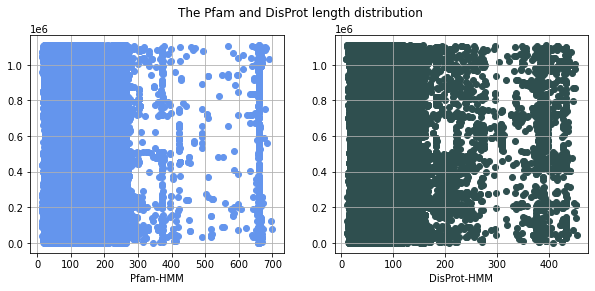

In [28]:
# Plot the percentage distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.scatter(noverlap_total_df['length_pfam'], noverlap_total_df.index, color='cornflowerblue', label='Overlapping')
ax2.scatter(noverlap_total_df['ali_length'], noverlap_total_df.index, color='darkslategray', label='Overlapping')
ax1.set_xlabel('Pfam-HMM')
ax2.set_xlabel('DisProt-HMM')
ax1.grid()
ax2.grid()
plt.suptitle('The Pfam and DisProt length distribution')
plt.show()

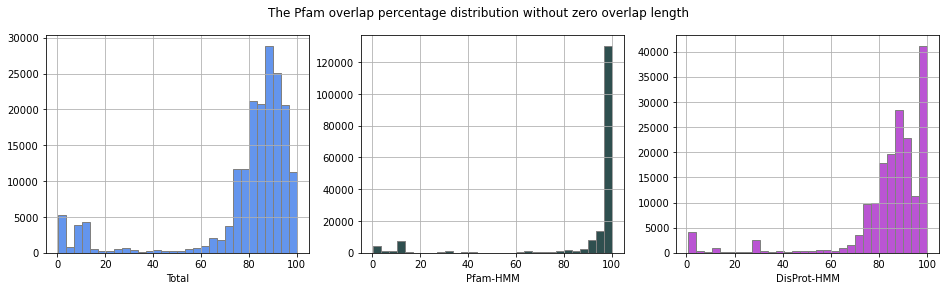

In [15]:
# Plot the percentage distribution
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.hist(overlap_total_df['overl_perc'], bins=30, edgecolor='gray', color='cornflowerblue', alpha=1, label='Overlapping')
ax2.hist(overlap_total_df['overl_pfam'], bins=30, edgecolor='gray', color='darkslategray', alpha=1, label='Overlapping')
ax3.hist(overlap_total_df['overl_ali'], bins=30, edgecolor='gray', color='mediumorchid', alpha=1, label='Overlapping')
ax1.set_xlabel('Total')
ax2.set_xlabel('Pfam-HMM')
ax3.set_xlabel('DisProt-HMM')
ax1.grid()
ax2.grid()
ax3.grid()
plt.suptitle('The Pfam overlap percentage distribution without zero overlap length')
plt.show()

In [16]:
# # Plot the histogram of overlaps % for Pfam and HMM
# plt.rcParams['figure.figsize'] = [6, 4]

# plt.hist([pfam_clustal['overl_pfam'], pfam_clustal['overl_ali']],
#              bins=10, alpha=0.5, color=['green', 'purple'],
#              label=['Pfam-HMM', 'DisProt-HMM'])

# plt.xlabel('Overlap percentage')
# plt.ylabel('Number of instances')
# plt.legend()
# plt.grid()
# plt.title('The overlaps distribution (Pfam-HMM and DisProt-HMM) across the ClustalOmega hmmsearch results against RP 75%')
# plt.tight_layout()
# plt.show()

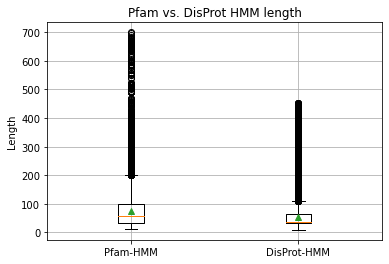

In [23]:
# plt.violinplot([noverlap_total_df['length_pfam'], noverlap_total_df['ali_length']],
#                showmeans=True)
plt.boxplot([noverlap_total_df['length_pfam'], noverlap_total_df['ali_length']],
               showmeans=True)
plt.xticks([1, 2], ['Pfam-HMM', 'DisProt-HMM'])
plt.ylabel('Length')
plt.title('Pfam vs. DisProt HMM length')
plt.grid(True)
plt.show()

In [21]:
print('The mean of HMM overlap with both Pfam-HMM and DisProt-HMM (ClustalOmega): {:.2f}%'.format(pfam_clustal['overl_perc'].mean()))

The mean of HMM overlap with both Pfam-HMM and DisProt-HMM (ClustalOmega): 12.72%


In [22]:
print('The mean of HMM overlap with Pfam-HMM (ClustalOmega): {:.2f}%'.format(pfam_clustal['overl_pfam'].mean()))

The mean of HMM overlap with Pfam-HMM (ClustalOmega): 14.47%


In [23]:
print('The mean of HMM overlap with Disprot-HMM (ClustalOmega): {:.2f}%'.format(pfam_clustal['overl_ali'].mean()))

The mean of HMM overlap with Disprot-HMM (ClustalOmega): 13.63%


In [24]:
print('The difference between mean of HMM and Pfam overlap (ClustalOmega): {:.2f}%'.format(pfam_clustal['overl_ali'].mean() - pfam_clustal['overl_pfam'].mean()))

The difference between mean of HMM and Pfam overlap (ClustalOmega): -0.84%
